<hr>
<div style="background-color: lightgray; padding: 20px; color: black;">
<div>
<img src="https://th.bing.com/th/id/R.3cd1c8dc996c5616cf6e65e20b6bf586?rik=09aaLyk4hfbBiQ&riu=http%3a%2f%2fcidics.uanl.mx%2fwp-content%2fuploads%2f2016%2f09%2fcimat.png&ehk=%2b0brgMUkA2BND22ixwLZheQrrOoYLO3o5cMRqsBOrlY%3d&risl=&pid=ImgRaw&r=0" style="float: right; margin-right: 30px;" width="200"/> 
<font size="5.5" color="8C3061"><b>Evaluación de los Modelos</b></font> <br>
<font size="4.5" color="8C3061"><b>Aprendizaje de Máquina - Tarea 1 </b></font> 
</div>
<div style="text-align: left">  <br>
Edison David Serrano Cárdenas. <br>
MSc en Matemáticas Aplicadas <br>
CIMAT - Sede Guanajuato <br>
</div>

</div>
<hr>


Cargar librerías:

In [93]:
# load basic libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import tensorflow as tf
from numpy.linalg import pinv
from sklearn.metrics import accuracy_score, recall_score, f1_score

Cargar datos:

In [11]:
# Directory where the generated data splits are saved
generate_data_dir = './generate_data'

# File paths for the split datasets
val_data_file = os.path.join(generate_data_dir, 'X_val.npy')
test_data_file = os.path.join(generate_data_dir, 'X_test.npy')
val_labels_file = os.path.join(generate_data_dir, 'y_val.npy')
test_labels_file = os.path.join(generate_data_dir, 'y_test.npy')

# Load the saved datasets
X_val = np.load(val_data_file)
X_test = np.load(test_data_file)
y_val = np.load(val_labels_file)
y_test = np.load(test_labels_file)

## <font color="8C3061" >**Cargar los modelos**</font>


Adicionar clases necesarias para cargar los modelos:

In [24]:
class BinaryDense(Dense):
    def __init__(self, units, activation=None, use_bias=True, **kwargs):
        super(BinaryDense, self).__init__(units, activation=activation, use_bias=use_bias, **kwargs)

    def call(self, inputs):
        binary_weights = tf.sign(self.kernel)  # Force weights to be binary {-1, 1}
        outputs = tf.matmul(inputs, binary_weights)
        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            outputs = self.activation(outputs)
        return outputs

In [25]:
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        # Randomly initialize the weights between the input layer and hidden layer
        self.input_weights = np.random.randn(input_size, hidden_size) * 0.5
        # Randomly initialize the biases for the hidden layer
        self.biases = np.random.randn(hidden_size) * 0.5
        self.hidden_size = hidden_size
        self.output_size = output_size
    
    # Activation function (sigmoid)
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Train the ELM by finding the output weights
    def train(self, X_train, y_train):
        # Compute the hidden layer output
        H = self.sigmoid(np.dot(X_train, self.input_weights) + self.biases)
        
        # Compute the pseudo-inverse of H to get the output weights
        H_pseudo_inv = pinv(H)
        
        # Compute the output weights (beta)
        self.output_weights = np.dot(H_pseudo_inv, y_train)
    
    # Predict on new data
    def predict(self, X):
        # Compute hidden layer output
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        # Compute the final output
        output = np.dot(H, self.output_weights)
        return output
    
class ELMWithLasso:
    def __init__(self, input_size, hidden_size, output_size, alpha=1.0):
        self.input_weights = np.random.randn(input_size, hidden_size) * 0.5
        self.biases = np.random.randn(hidden_size) * 0.5
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alpha = alpha
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def train(self, X_train, y_train):
        # Hidden layer output
        H = self.sigmoid(np.dot(X_train, self.input_weights) + self.biases)
        
        # Reshape y_train to match the expected input for Lasso
        y_train = y_train.reshape(-1, self.output_size)
        
        # Lasso regression for each output class
        self.output_weights = np.zeros((self.hidden_size, self.output_size))
        for i in range(self.output_size):
            lasso = Lasso(alpha=self.alpha)
            lasso.fit(H, y_train[:, i])
            self.output_weights[:, i] = lasso.coef_
    
    def predict(self, X):
        # Hidden layer output
        H = self.sigmoid(np.dot(X, self.input_weights) + self.biases)
        
        # Final output prediction
        output = np.dot(H, self.output_weights)  # Note: no transpose needed here
        return output
    
class ELMWithRidge:
    def __init__(self, input_size, hidden_size, output_size, alpha=1.0):
        # Randomly initialize the weights between the input layer and hidden layer
        self.input_weights = np.random.randn(input_size, hidden_size) * 0.5
        # Randomly initialize the biases for the hidden layer
        self.biases = np.random.randn(hidden_size) * 0.5
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alpha = alpha  # Ridge regularization parameter
    
    # Activation function (sigmoid)
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Train the ELM using Ridge for regularization
    def train(self, X_train, y_train):
        # Compute the hidden layer output
        H = self.sigmoid(np.dot(X_train, self.input_weights) + self.biases)
        
        # Reshape y_train to match the expected input for Ridge
        y_train = y_train.reshape(-1, self.output_size)
        
        # Use Ridge regression to compute the output weights with regularization
        self.output_weights = np.zeros((self.hidden_size, self.output_size))
        for i in range(self.output_size):
            ridge = Ridge(alpha=self.alpha)
            ridge.fit(H, y_train[:, i])
            self.output_weights[:, i] = ridge.coef_
            
class ELMWithElasticNet:
    def __init__(self, input_size, hidden_size, output_size, alpha=1.0, l1_ratio=0.5):
        # Randomly initialize the weights between the input layer and hidden layer
        self.input_weights = np.random.randn(input_size, hidden_size) * 0.5
        # Randomly initialize the biases for the hidden layer
        self.biases = np.random.randn(hidden_size) * 0.5
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alpha = alpha  # Regularization strength
        self.l1_ratio = l1_ratio  # Mix ratio for L1 (Lasso) and L2 (Ridge) penalties
    
    # Activation function (sigmoid)
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # Train the ELM using ElasticNet regularization
    def train(self, X_train, y_train):
        # Compute the hidden layer output
        H = self.sigmoid(np.dot(X_train, self.input_weights) + self.biases)
        
        # Reshape y_train to match the expected input for ElasticNet
        y_train = y_train.reshape(-1, self.output_size)
        
        # Use ElasticNet regression to compute the output weights with L1/L2 regularization
        self.output_weights = np.zeros((self.hidden_size, self.output_size))
        for i in range(self.output_size):
            elasticnet = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio)
            elasticnet.fit(H, y_train[:, i])
            self.output_weights[:, i] = elasticnet.coef_

In [29]:
# Load the ELM model parameters
def load_elm_model(filepath):
    data = np.load(filepath)
    input_weights = data['input_weights']
    biases = data['biases']
    output_weights = data['output_weights']
    
    # Create a new ELM instance with the correct sizes
    input_size = input_weights.shape[0]
    hidden_size = input_weights.shape[1]
    output_size = output_weights.shape[1]
    
    elm = ELM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    elm.input_weights = input_weights
    elm.biases = biases
    elm.output_weights = output_weights
    
    print(f"ELM model loaded from {filepath}.npz")
    return elm

# Function to convert predictions to one-hot encoded format
def convert_predictions_to_onehot(predictions, num_classes):
    class_indices = np.argmax(predictions, axis=1)
    one_hot_predictions = np.eye(num_classes)[class_indices]
    return one_hot_predictions


Cargar los modelos:

In [28]:
mlp_model = load_model('models/multilayer_perceptron.keras')
mlb_model = load_model('models/ml_binary_weights.keras', custom_objects={'BinaryDense': BinaryDense})
elm_loaded = load_elm_model('models/elm_model.npz')
elm_lasso = load_elm_model('models/elm_lasso_model.npz')
elm_ridge = load_elm_model('models/elm_ridge_model.npz')
elm_elasticnet = load_elm_model('models/elm_elasticnet_model.npz')

ELM model loaded from models/elm_model.npz.npz
ELM model loaded from models/elm_lasso_model.npz.npz
ELM model loaded from models/elm_ridge_model.npz.npz
ELM model loaded from models/elm_elasticnet_model.npz.npz


## <font color="8C3061" >**Evaluación de los modelos**</font>

In [83]:
# Define a function to evaluate MLP models
def evaluate_mlp_model(model, X_test, y_test):
    predictions = model.predict(X_test)  # Assuming classification
    ss = convert_predictions_to_onehot(predictions,7)
    return {
        'Accuracy': accuracy_score(y_test, ss),
        'Recall': recall_score(y_test, ss, average='weighted'),
        'F1 Score': f1_score(y_test, ss, average='weighted')
    }
    
def evaluate_all_model(X,y):
    results = {
    'MLP': evaluate_mlp_model(mlp_model, X, y),
    'MLB': evaluate_mlp_model(mlb_model, X, y),
    'ELM': evaluate_mlp_model(elm_loaded, X, y),
    'ELM Lasso': evaluate_mlp_model(elm_lasso, X, y),
    'ELM Ridge': evaluate_mlp_model(elm_ridge, X, y),
    'ELM ElasticNet': evaluate_mlp_model(elm_elasticnet, X, y)
    }
    
    df_scores = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [result['Accuracy'] for result in results.values()],
    'Recall': [result['Recall'] for result in results.values()],
    'F1 Score': [result['F1 Score'] for result in results.values()]
    })
    
    return df_scores

In [84]:
df_scores_test = evaluate_all_model(X_test,y_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


La métrica con mayor valor asociado va a ser el Accuracy por elección primaria de esta.

In [88]:
df_scores_test.style.background_gradient(cmap='Reds', subset=['Accuracy', 'Recall', 'F1 Score'])

,Model,Accuracy,Recall,F1 Score
0,MLP,0.243571,0.243571,0.136039
1,MLB,0.142286,0.142286,0.051704
2,ELM,0.226571,0.226571,0.180985
3,ELM Lasso,0.138571,0.138571,0.033730
4,ELM Ridge,0.250857,0.250857,0.100618
5,ELM ElasticNet,0.138571,0.138571,0.033730


El modelo con mejor desempeño es la Máquina de aprendizaje extremo con regularización Ridge sobre la capa de salida.

## <font color="8C3061" >**Rendimiento del mejor modelo**</font>

Evaluación sobre el conjunto de validación:

In [109]:
results_best_model = evaluate_mlp_model(mlp_model,X_val,y_val)
print("Final performance best model: ",results_best_model)

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Final performance best model:  {'Accuracy': 0.24714285714285714, 'Recall': 0.24714285714285714, 'F1 Score': 0.13799201110755976}


Matrix de Confusión en el conjunto de validación:

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


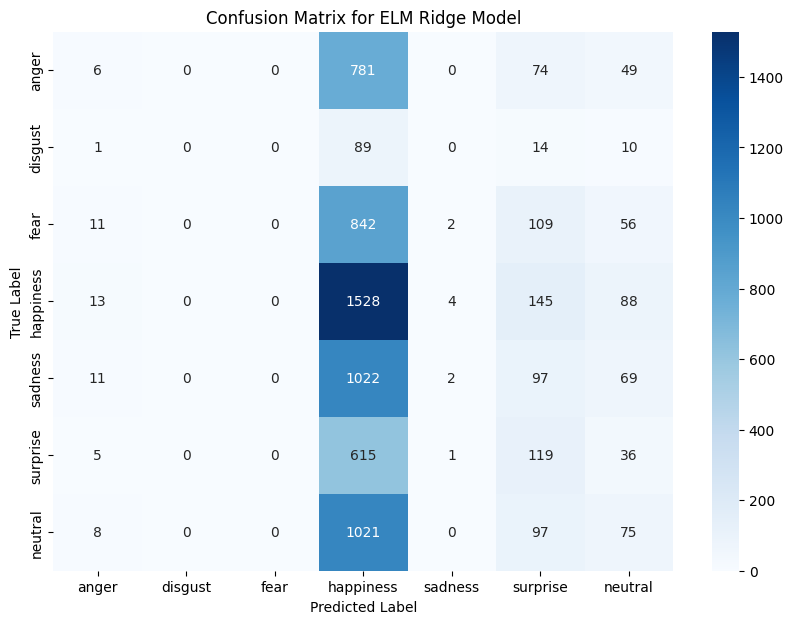

In [112]:
predictions =mlp_model.predict(X_val)  # Assuming classification
y_pred = np.argmax(predictions,axis=1)
y_val_labels =  np.argmax(y_val, axis=1)

emotions_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Compute the confusion matrix
cm = confusion_matrix(y_val_labels, y_pred)
labels = [emotions_labels[i] for i in range(len(emotions_labels))]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for ELM Ridge Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
